<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

# 88 Constellations Instance Segmention using maskrcnn - Detectron2

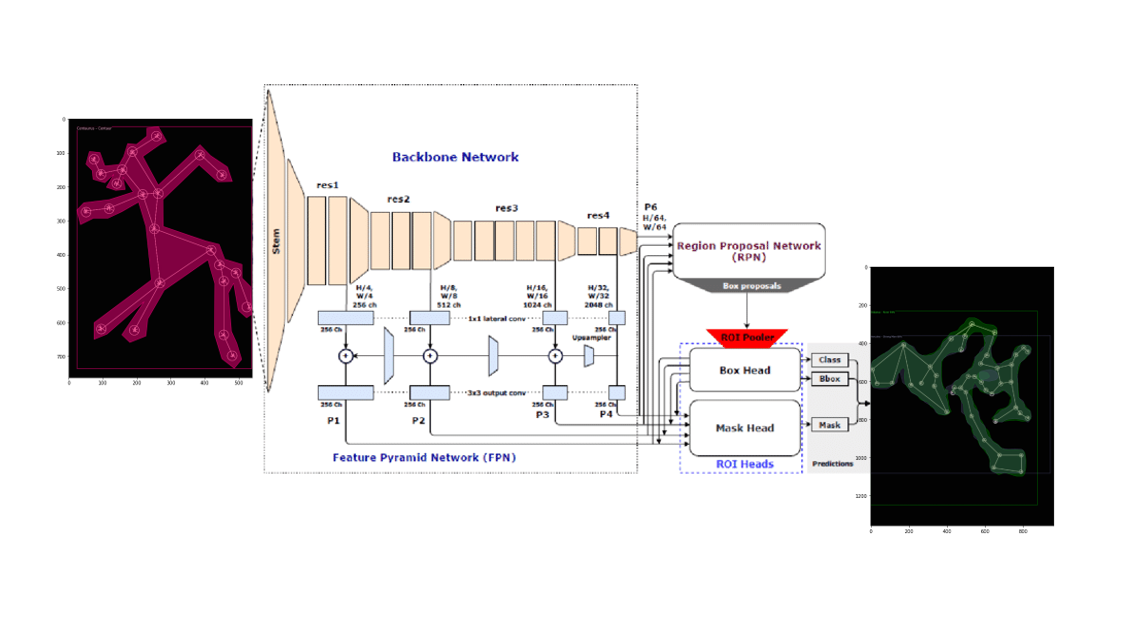

##Reference: 
1. [Detectron2](https://detectron2.readthedocs.io/en/latest/)
2. [Tanner Gilbert](https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model)

In [1]:
#!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 15 kB/s 
     |████████████████████████████████| 17.3 MB 958 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0+cu101 which is incompatible.


In [2]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 24.0 MB/s 
     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 74 kB 2.0 MB/s 
     |████████████████████████████████| 147 kB 31.3 MB/s 
     |████████████████████████████████| 130 kB 32.3 MB/s 
     |████████████████████████████████| 749 kB 33.8 MB/s 
     |████████████████████████████████| 843 kB 25.9 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |████████████████████████████████| 112 kB 48.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220506-py3-none-any.whl size=61284 sha256=b870868bf48c15c5f64df39c5966e5890e00fb6ca3db468295ae76767a1dcf1a
  Stored in directory: /root/.cache/pip/wheels/f5/ef/3c/708de8799f89f0871bd209866831fe3885db93fa090608fa73
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=55d

## Get data

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [18]:
!ls 'Constellations Segmentation'

test  train


In [19]:
import pandas as pd
dfs = pd.read_excel('Constellations Segmentation/Mapper.xlsx')

In [20]:
dfs

,Constellation Image file,Constellation name
0,image0.jpg,Andromeda – Royal Sea Monster Bait
1,image1.jpg,Antlia – Air Pump
2,image2.jpg,Apus – Bird of Paradise
3,image3.jpg,Aquarius – Water-Bearer
4,image4.jpg,Aquila – Thunderbolt Eagle
...,...,...
83,image83.jpg,Ursa Minor – Small bear
84,image84.jpg,Vela – Sails of Argo Navis
85,image85.jpg,Virgo – Young Maiden
86,image86.jpg,Volans – Flying Fish


In [21]:
y = dfs['Constellation name'].tolist()

In [22]:
y

['Andromeda – Royal Sea Monster Bait',
 'Antlia – Air Pump',
 'Apus – Bird of Paradise',
 'Aquarius – Water-Bearer',
 'Aquila – Thunderbolt Eagle',
 'Ara – Altar',
 'Aries – Ram',
 'Auriga – Charioteer',
 'Boötes – Herdsman',
 'Caelum – Chisel',
 'Camelopardalis – Giraffe',
 'Cancer – Crab',
 'Canes Venatici – Hunting Dogs',
 'Canis Major – Big Dog',
 'Canis Minor – Small Dog',
 'Capricornus – Sea Goat',
 'Carina – Keel of Argo Navis',
 'Cassiopeia – Vain Queen',
 'Centaurus – Centaur',
 'Cepheus – King',
 'Cetus – Whale',
 'Chamaeleon – Chameleon',
 'Circinus – Compass',
 'Columba – Dove',
 'Coma Berenices – Berenice’s Hair',
 'Corona Australis – Southern Crown',
 'Corona Borealis – Northern Crown',
 'Corvus – Raven',
 'Crater – Cup',
 'Crux – Southern Cross',
 'Cygnus – Swan',
 'Delphinus – Dolphin',
 'Dorado – Fish',
 'Draco – Dragon',
 'Equuleus – Little Horse',
 'Eridanus – River',
 'Fornax – Furnace',
 'Gemini – Twins',
 'Grus – Crane',
 'Hercules – Strong Man',
 'Horologium – Pe

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.



In [23]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_constellation_dicts(directory):
    classes = dfs['Constellation name'].tolist()
    dataset_dicts = []
    for idx, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 1527
        record["width"] = 1080
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("constellation_" + d, lambda d=d: get_constellation_dicts('Constellations Segmentation/' + d))
    MetadataCatalog.get("constellation_" + d).set(thing_classes= dfs['Constellation name'].tolist())
constellation_metadata = MetadataCatalog.get("constellation_train")

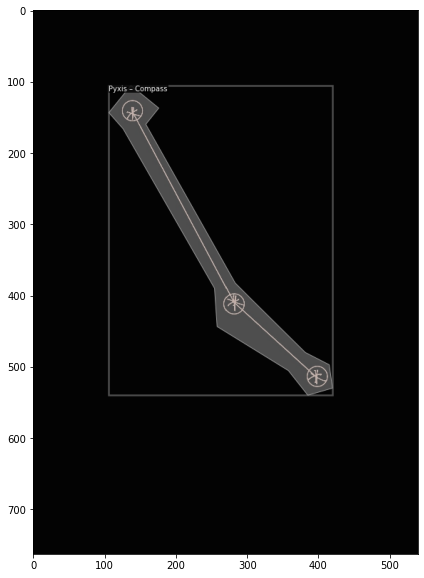

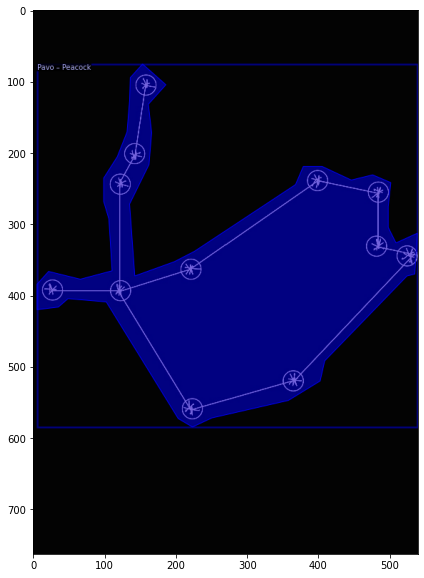

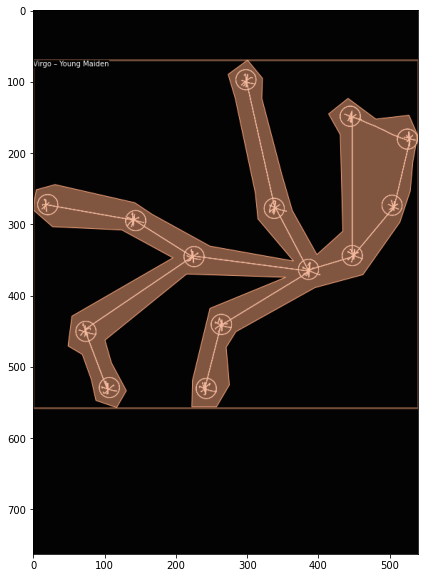

In [27]:
import random

dataset_dicts = get_constellation_dicts("Constellations Segmentation/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=constellation_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Model training

In [14]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("constellation_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 4000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 88

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/07 21:48:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:05, 31.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (89, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (89,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (352, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (352,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model du

[05/07 21:48:22 d2.engine.train_loop]: Starting training from iteration 0
[05/07 21:48:50 d2.utils.events]:  eta: 1:31:08  iter: 19  total_loss: 5.479  loss_cls: 4.666  loss_box_reg: 0.09134  loss_mask: 0.6924  loss_rpn_cls: 0.01422  loss_rpn_loc: 0.01544  time: 1.3936  data_time: 0.0336  lr: 4.9953e-06  max_mem: 2453M
[05/07 21:49:17 d2.utils.events]:  eta: 1:30:23  iter: 39  total_loss: 5.043  loss_cls: 4.259  loss_box_reg: 0.09257  loss_mask: 0.6929  loss_rpn_cls: 0.01651  loss_rpn_loc: 0.01604  time: 1.3712  data_time: 0.0123  lr: 9.9902e-06  max_mem: 2453M
[05/07 21:49:43 d2.utils.events]:  eta: 1:29:56  iter: 59  total_loss: 4.146  loss_cls: 3.339  loss_box_reg: 0.08344  loss_mask: 0.6927  loss_rpn_cls: 0.01219  loss_rpn_loc: 0.01178  time: 1.3532  data_time: 0.0119  lr: 1.4985e-05  max_mem: 2453M
[05/07 21:50:10 d2.utils.events]:  eta: 1:29:48  iter: 79  total_loss: 2.591  loss_cls: 1.742  loss_box_reg: 0.08926  loss_mask: 0.6928  loss_rpn_cls: 0.01465  loss_rpn_loc: 0.01397  ti

## Use model for inference

Now, we can perform inference on our test set by creating a predictor object.

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("constellation_test", )
predictor = DefaultPredictor(cfg)

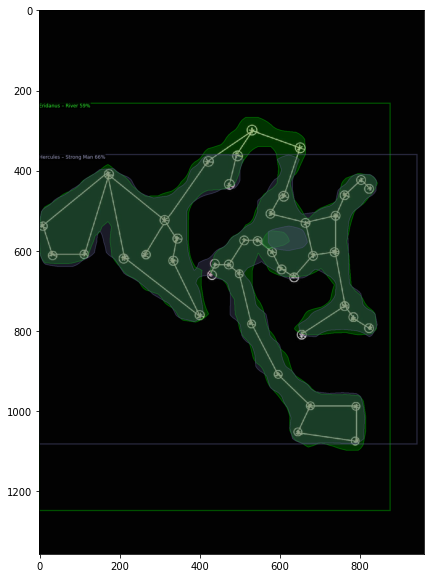

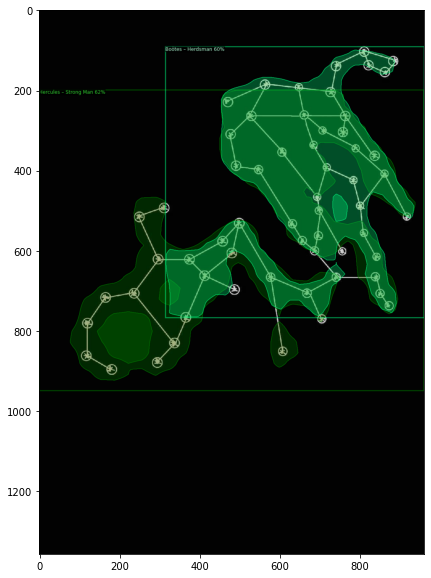

In [16]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_constellation_dicts('Constellations Segmentation/test')
for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=constellation_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

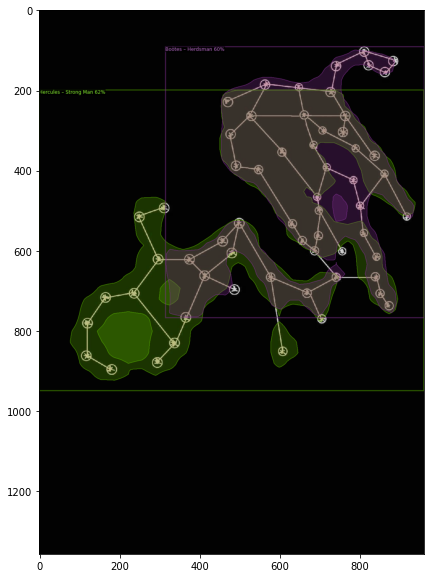

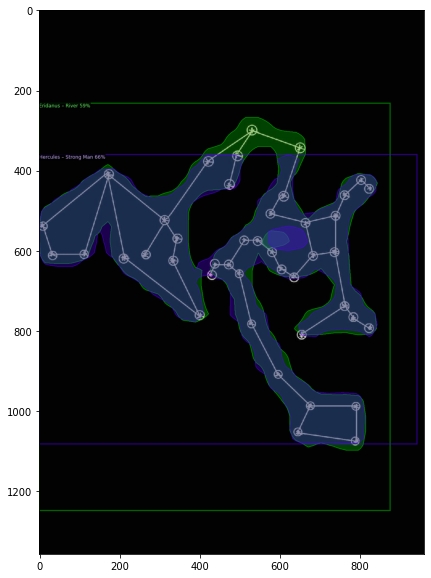

In [17]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_constellation_dicts('Constellations Segmentation/test')
for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=constellation_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
#############################################################